# Ferret data
First, we load the imaging data used in Macke et al. (2011). Its size is (npixels_x, npixels_y, conditions, trials).

In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

data = scipy.io.loadmat('data/ferretdata.mat')
data = data['dat'] # data is stored in a dict
data.shape

(126, 252, 8, 100)

Reshape the data to (conditions, trials, npixels_x, npixels_y) and take a 40x40 pixel patch.

In [2]:
R = np.transpose(data[26:,:200,:,:], (2,3,0,1))
print(R.shape)

# take only a small part of the image (for performance reasons)
R = R[:,:,38:58,106:136]

# downsample image
#R = R[:,:,::3,::3]

size = R.shape[2:]
n = size[0] * size[1]
R.shape

(8, 100, 100, 200)


(8, 100, 20, 30)

## Plot responses
Visualize the responses for the small patch

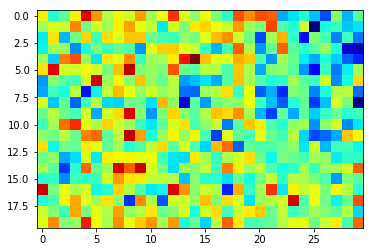

In [3]:
plt.imshow(R[0,np.random.randint(100),:,:], cmap='jet')
plt.show()

## Maximum likelihood solution
Compute the solution using vector averaging (for details see OPM.ipynb)

In [4]:
from opm import calculate_map, plot_opm, plot_amplitude_map
from opm.response import create_stimuli

In [5]:
angles = [i * np.pi / 4 for i in range(4)]*2

V = create_stimuli([1.], angles, 100)
V.shape

(8, 100, 3)

In [6]:
m = calculate_map(R, V)
m_hat = m[0] + 1j * m[1]

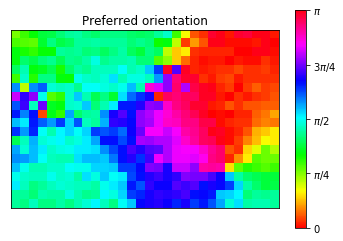

In [7]:
plot_opm(m_hat, pinwheels=False, shade=False, rmax=80)
plt.show()

## Gaussian Process method
Compute a smooth OPM using the GP method (see BayesianOPM.ipynb)

In [8]:
from opm.gp import GaussianProcessOPM

In [9]:
gp = GaussianProcessOPM(size=R.shape[2:], prior_method='icd', prior_rank=500)

In [23]:
mu_post = gp.fit(stimuli=V, responses=R, noise='factoran', verbose=True, noise_kwargs={'iterations':3, 'q':2})

*** Estimating prior hyperparameters ***
{'sigma': 4.441399047063159, 'alpha': 2.8433287234972293}
*** Fitting prior ***
*** Fitting posterior ***
Fitting noise model: iteration 1
Fitting noise model: iteration 2
Fitting noise model: iteration 3


In [24]:
#mu = m.reshape(3, size)
result = mu_post[0] + 1j * mu_post[1]

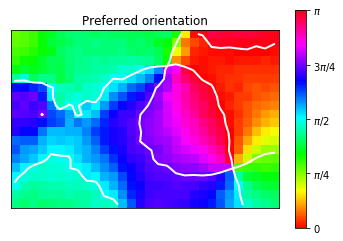

In [25]:
f, ax = plot_opm(result)
plt.show()

### Noise covariance
We examine the noise variances (i.e. the diagonal of the noise covariance matrix).

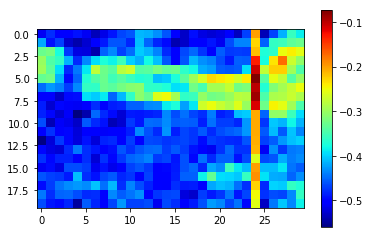

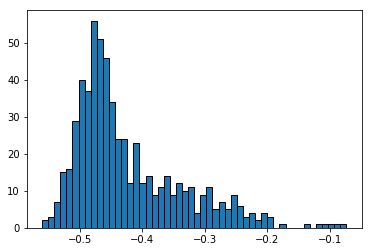

In [26]:
noise_var = gp.noise.variance

plt.imshow(np.log10(noise_var).reshape(*R.shape[2:]), cmap='jet')
plt.colorbar()
plt.show()

plt.hist(np.log10(noise_var), bins=50, edgecolor='black')
plt.show()

In [14]:
def cov2corr(cov):
    std = np.sqrt(np.diag(cov))
    std_mat = np.tile(std, (cov.shape[0],1))
    return cov / std_mat / std_mat.T

cov2corr(gp.noise_cov)

array([[ 1.        ,  0.11620494, -0.04739863, ...,  0.08275058,
         0.06044977,  0.07859663],
       [ 0.11620494,  1.        , -0.03689163, ...,  0.08178572,
         0.06209477,  0.07884165],
       [-0.04739863, -0.03689163,  1.        , ...,  0.00133604,
         0.01161343,  0.00652673],
       ...,
       [ 0.08275058,  0.08178572,  0.00133604, ...,  1.        ,
         0.07908519,  0.09265703],
       [ 0.06044977,  0.06209477,  0.01161343, ...,  0.07908519,
         1.        ,  0.08175567],
       [ 0.07859663,  0.07884165,  0.00652673, ...,  0.09265703,
         0.08175567,  1.        ]])

In [15]:
def avg_neighbor_corr(gp, radius=2):
    
    # size of the map (x, y)
    size = gp.size
    
    # convert noise covariance to correlation matrix
    noise_corr = cov2corr(gp.noise_cov)
    
    # initialize empty image
    neighbor_corr = np.zeros(size)
    
    # for each index
    # i is the 1d index
    # ix is the 2d (x, y) index
    for i, ix in enumerate(gp.idx):
        # compute euclidean distance from this index to all others
        dist = np.sqrt(np.sum(np.square(ix - gp.idx), axis=1))
        
        # keep all indices smaller than some distance
        neighbors = np.where(dist <= radius)[0]
        # remove the index itself
        neighbors = neighbors[neighbors != i]
    
        # compute average correlation between i and the neighbors
        neighbor_corr[ix[0], ix[1]] = np.mean(noise_corr[i, neighbors])
            
    return neighbor_corr

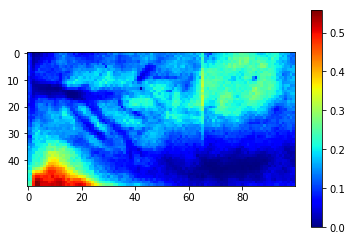

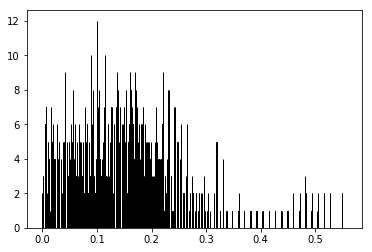

In [16]:
nbcorr = avg_neighbor_corr(gp, radius=2)

plt.imshow(nbcorr, cmap='jet')
plt.colorbar()
plt.show()

plt.hist(nbcorr, bins=50, edgecolor='black')
plt.show()